In [1]:
import csv
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from io import StringIO
from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/ECE1786 Project/Dataset/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
!unzip dataset_all_genres.csv.zip

Archive:  dataset_all_genres.csv.zip
replace dataset_all_genres.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [24]:
#track_name, lyrics, primary_genre, lyrics
#read the csv file into dataframe but only keep the genres chosen for classification
df = pd.read_csv('dataset_all_genres.csv',error_bad_lines=False)
genres = ["R&B","Pop","Rock","Hip Hop","Blues","Country","Indie","EDM"]
df = df[df['primary_genre'].isin(genres)]

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [25]:
df

,track_name,lyrics,primary_genre,secondary_genre
0,Careless Whisper,I feel so unsure\nAs I take your hand and lead...,Pop,NaN
1,Could You Be Loved / Citação Musical do Rap: S...,"Don't let them fool, ya\nOr even try to school...",Pop,NaN
2,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here\nDon't be c...",Pop,NaN
3,Easy,"Know it sounds funny\nBut, I just can't stand ...",Pop,NaN
4,For Your Babies (The Voice cover),You've got that look again\nThe one I hoped I ...,Pop,NaN
...,...,...,...,...
95071,I Wanna Know,"There's a light on your skin, painted gold on ...",EDM,NaN
95072,Wildcard (feat. Sidnie Tipton),I come around the turn and people stop and sta...,EDM,NaN
95073,Andrew's Break,I have never been aboard a steamer I am just c...,EDM,NaN
95074,Do Bad Well (feat. Nevve),"Oh, my daddy taught me well There's some devil...",EDM,NaN


In [28]:
df['primary_genre'].value_counts()

Rock       25177
Pop        13759
Indie      12998
Hip Hop     8412
Country     7377
R&B         5309
Blues       2038
EDM         1758
Name: primary_genre, dtype: int64

In [29]:
df['secondary_genre'].value_counts()

Rock       6243
R&B        4201
Pop        3585
Indie      2371
Hip Hop    2207
Blues      1707
Country    1287
Name: secondary_genre, dtype: int64

In [32]:
df['secondary_genre'].value_counts().sum()

21601

In [38]:
df[df['secondary_genre']=='Pop']['primary_genre'].value_counts()

R&B        948
Indie      891
Rock       759
Hip Hop    521
Country    466
Name: primary_genre, dtype: int64

In [36]:
df[['primary_genre','secondary_genre']].value_counts()

primary_genre  secondary_genre
Indie          Rock               4518
Pop            R&B                2174
Rock           Indie              1817
Hip Hop        R&B                1802
Rock           Blues              1493
R&B            Hip Hop            1366
               Pop                 948
Indie          Pop                 891
Rock           Country             852
               Pop                 759
Pop            Rock                746
               Indie               554
Blues          Rock                536
Hip Hop        Pop                 521
Country        Pop                 466
Rock           Hip Hop             434
Pop            Hip Hop             407
               Country             333
Country        Rock                274
Indie          R&B                 225
Hip Hop        Rock                161
Country        Blues               120
R&B            Blues                69
Blues          Country              54
Indie          Country           

In [5]:
print(df.iloc[0])

track_name                                          Careless Whisper
lyrics             I feel so unsure\nAs I take your hand and lead...
primary_genre                                                    Pop
secondary_genre                                                  NaN
Name: 0, dtype: object


In [6]:
df['primary_genre'].value_counts()

Rock       25177
Pop        13759
Indie      12998
Hip Hop     8412
Country     7377
R&B         5309
Blues       2038
EDM         1758
Name: primary_genre, dtype: int64

In [7]:
#just use 500 from each genre for the baseline model
# change to 1750
df_baseline = df.groupby('primary_genre').sample(n=1750, random_state=200)

In [8]:
#preprocess data
stop_words = set(stopwords.words('english'))

def preprocess_lyrics(lyrics, remove_stop_words = True):
  #change words to lower case
  word_tokens = word_tokenize(lyrics)
  lyrics = [w for w in word_tokens if not w.lower() in stop_words]

  if remove_stop_words:
    filtered_lyrics = []
    for w in word_tokens:
      if w not in stop_words:
        filtered_lyrics.append(w)
    return " ".join(filtered_lyrics)
  else:
    return word_tokens

def preprocess_dataset(dataframe, remove_stop_words = True):
  genres = []
  lyrics = []
  for index, row in dataframe.iterrows():
    genres.append(row['primary_genre'])
    lyrics.append(preprocess_lyrics(row['lyrics'], remove_stop_words))
  return genres, lyrics
  

In [9]:
example = df_baseline['lyrics'].iloc[0]
lyric = preprocess_lyrics(example)

In [10]:
bs_genres, bs_lyrics = preprocess_dataset(df_baseline)

In [11]:
print(bs_lyrics[0])

Some people call junker Say I 'm loaded mind But I feel happy I feel good time Some say I use needle And say I sniff cocaine That 's best damn feeling That I 've ever seen So goodbye , goodbye whisky And long gin Just give reefer I wan na get high Well men crave chicken Some fellas crave steak But I 'll happy oh happy With slice yellow cake Some people call junker Say I 'm loaded time But I feel happy I feel good time


In [12]:
bs_dict = {"genres": bs_genres, "lyrics": bs_lyrics}
bs_df = pd.DataFrame(bs_dict)
bs_df.head()

,genres,lyrics
0,Blues,Some people call junker Say I 'm loaded mind B...
1,Blues,It 's got leaky carburetor A rusted floor Four...
2,Blues,I get weary evenin When suns goin . I get wear...
3,Blues,Lord knows I 've tried To 's right One whole y...
4,Blues,My baby gives love As good love I leave crying...


In [14]:
#add genre id to convert genre to labels
bs_df['genre_id'] = bs_df['genres'].factorize()[0]
genre_id_df = bs_df[['genres', 'genre_id']].drop_duplicates().sort_values('genre_id')
genre_to_id = dict(genre_id_df.values)
id_to_genre = dict(genre_id_df[['genre_id', 'genres']].values)
bs_df.head()

,genres,lyrics,genre_id
0,Blues,Some people call junker Say I 'm loaded mind B...,0
1,Blues,It 's got leaky carburetor A rusted floor Four...,0
2,Blues,I get weary evenin When suns goin . I get wear...,0
3,Blues,Lord knows I 've tried To 's right One whole y...,0
4,Blues,My baby gives love As good love I leave crying...,0


In [42]:
pd.set_option('display.max_colwidth', None)
df[df['lyrics'].str.contains(r'\[.*\]')]

track_name  \
24                         Crazy In Love (feat. Jay Z)   
29                                              Listen   
34                         Drunk In Love (Feat. Jay Z)   
38     Drunk In Love (Feat. Kanye West, Jay Z) (Remix)   
48                                            632-5792   
...                                                ...   
91754                                         Fearless   
91755                    Fearless (250 And Dark Stars)   
91767                                 Into The Gravity   
91771                              Lights Of Reedsport   
91776                                         Moonlite   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [15]:
#TFIDF- IDF BASELINE MODEL
def tfidf (df):
  tfidf = TfidfVectorizer(analyzer='word',stop_words = 'english')
  features = tfidf.fit_transform(df.lyrics).toarray()
  labels = df.genre_id
  return features, labels, tfidf

In [16]:
features, labels, vectorizer = tfidf(bs_df)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(features, labels,  stratify=labels, random_state = 200)

In [18]:
#Linear Support Vector Classifier
lsvc = LinearSVC().fit(x_train, y_train)
y_pred = lsvc.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, target_names=bs_df['genres'].unique()))

Accuracy: 0.44257142857142856
              precision    recall  f1-score   support

       Blues       0.55      0.62      0.58       438
     Country       0.48      0.53      0.50       438
         EDM       0.43      0.60      0.50       438
     Hip Hop       0.66      0.65      0.65       437
       Indie       0.40      0.37      0.39       438
         Pop       0.27      0.23      0.25       437
         R&B       0.43      0.35      0.39       437
        Rock       0.24      0.20      0.22       437

    accuracy                           0.44      3500
   macro avg       0.43      0.44      0.43      3500
weighted avg       0.43      0.44      0.43      3500



In [19]:
ft_names = vectorizer.get_feature_names()
ft_imps = lsvc.coef_

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


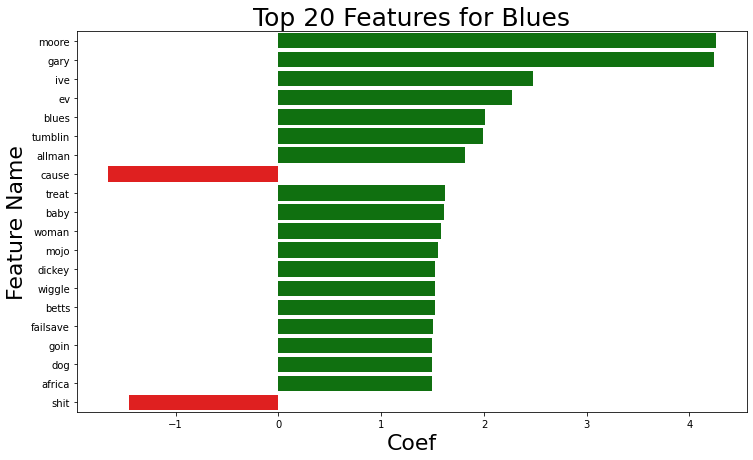

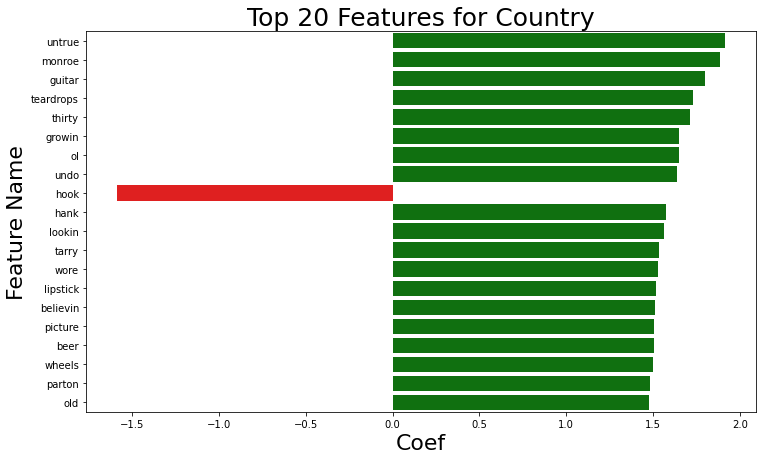

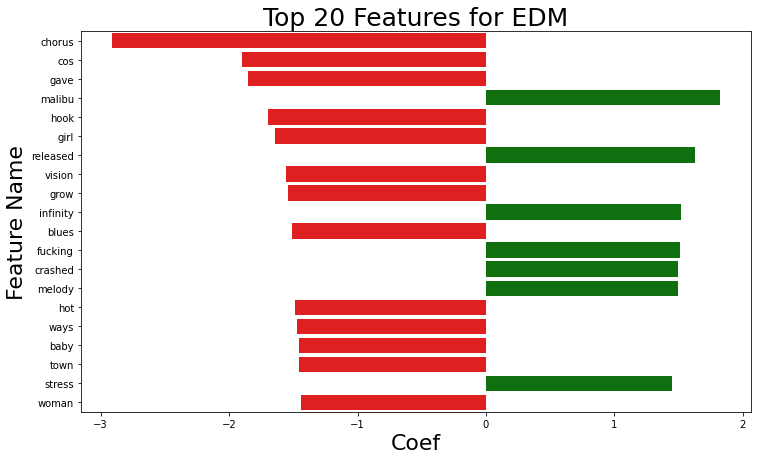

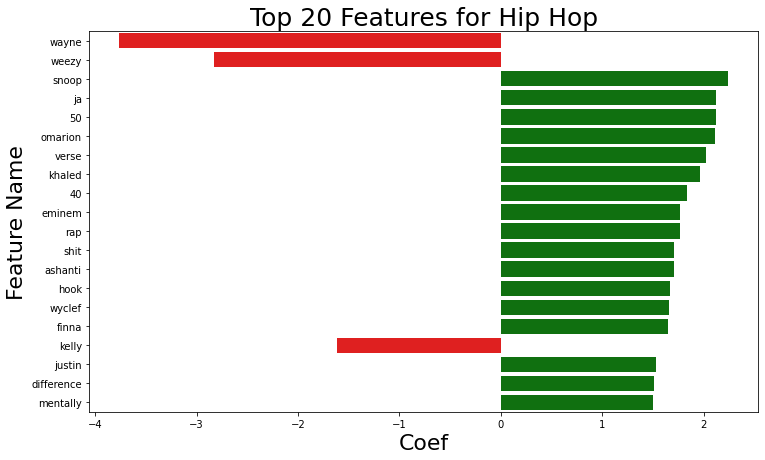

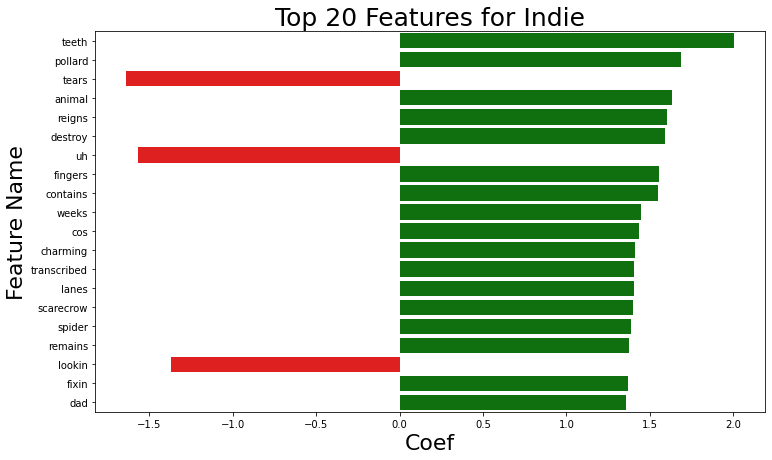

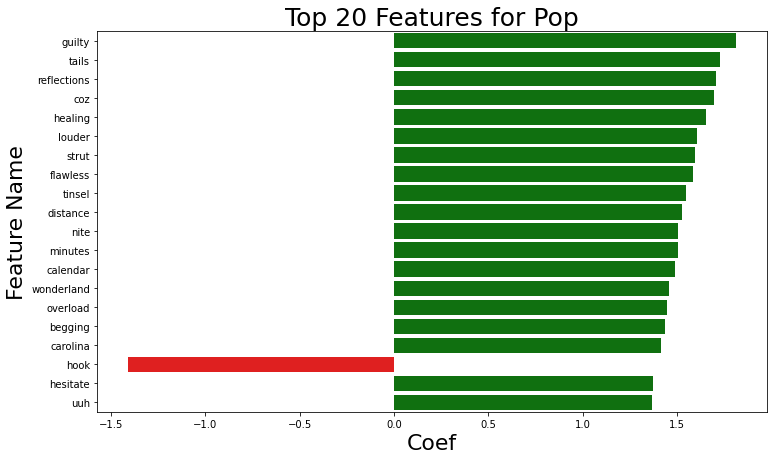

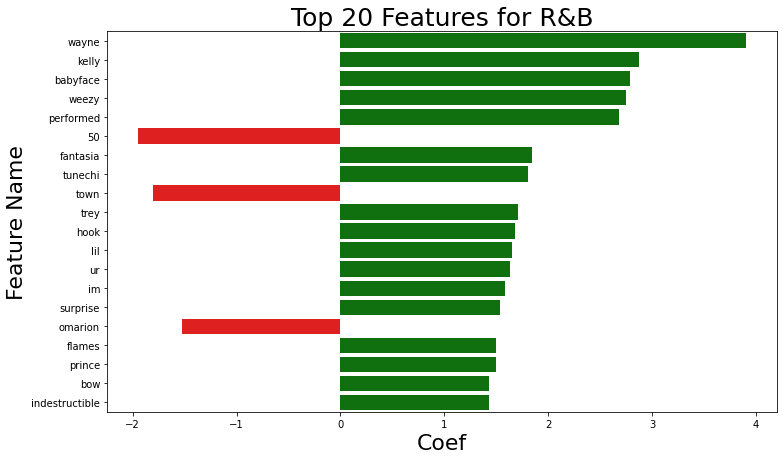

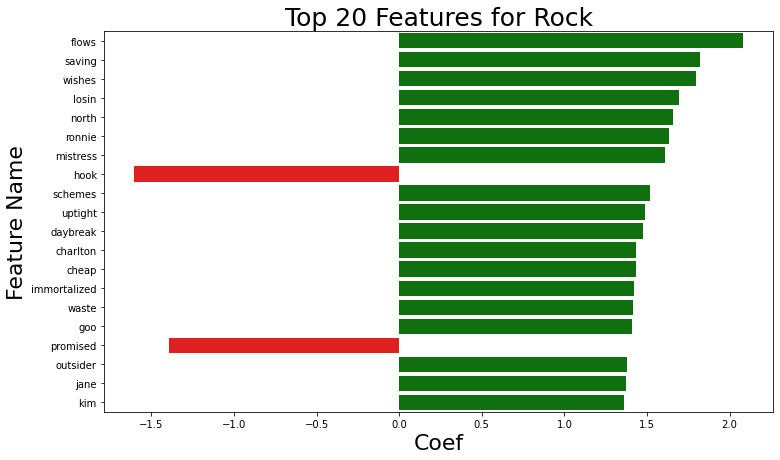

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

genre_labels = ['Blues', 'Country', 'EDM', 'Hip Hop', 'Indie', 'Pop', 'R&B', 'Rock']

for i in range(8):
  zipped = zip(ft_names, ft_imps[i])
  df = pd.DataFrame(zipped, columns=["feature", "value"])
  # Sort the features by the absolute value of their coefficient
  df["abs_value"] = df["value"].apply(lambda x: abs(x))
  df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
  df = df.sort_values("abs_value", ascending=False)



  fig, ax = plt.subplots(1, 1, figsize=(12, 7))
  # sns.barplot(x="feature",
  #             y="value",
  #             data=df.head(20),
  #           palette=df.head(20)["colors"])
  # ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
  # ax.set_title(f"Top 20 Features for {genre_labels[i]}", fontsize=25)
  # ax.set_ylabel("Coef", fontsize=22)
  # ax.set_xlabel("Feature Name", fontsize=22)
  sns.barplot(x="value",
              y="feature",
              data=df.head(20),
            palette=df.head(20)["colors"])
  # ax.set_yticklabels(ax.get_yticklabels(), rotation=90, fontsize=20)
  ax.set_title(f"Top 20 Features for {genre_labels[i]}", fontsize=25)
  ax.set_xlabel("Coef", fontsize=22)
  ax.set_ylabel("Feature Name", fontsize=22)

In [17]:
#Random Forests
rfc = RandomForestClassifier(n_estimators=300, random_state=200)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, target_names=bs_df['genres'].unique()))

Accuracy: 0.406
              precision    recall  f1-score   support

       Blues       0.41      0.67      0.51       125
     Country       0.48      0.44      0.46       125
         EDM       0.29      0.77      0.42       125
     Hip Hop       0.63      0.72      0.67       125
       Indie       0.36      0.14      0.20       125
         Pop       0.36      0.18      0.24       125
         R&B       0.48      0.23      0.31       125
        Rock       0.34      0.10      0.16       125

    accuracy                           0.41      1000
   macro avg       0.42      0.41      0.37      1000
weighted avg       0.42      0.41      0.37      1000



In [33]:
#Multinomial Naive Bayes
mnb = MultinomialNB().fit(x_train, y_train)
y_pred = mnb.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, target_names=bs_df['genres'].unique()))

Accuracy: 0.363
              precision    recall  f1-score   support

       Blues       0.59      0.54      0.56       125
     Country       0.38      0.50      0.43       125
         EDM       0.58      0.25      0.35       125
     Hip Hop       0.44      0.78      0.56       125
       Indie       0.41      0.06      0.10       125
         Pop       0.21      0.35      0.26       125
         R&B       0.26      0.37      0.31       125
        Rock       0.15      0.06      0.08       125

    accuracy                           0.36      1000
   macro avg       0.38      0.36      0.33      1000
weighted avg       0.38      0.36      0.33      1000



In [24]:
#Logistic Regression
logreg = LogisticRegression(random_state=200)
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, target_names=bs_df['genres'].unique()))

Accuracy: 0.406
              precision    recall  f1-score   support

       Blues       0.53      0.55      0.54       125
     Country       0.42      0.44      0.43       125
         EDM       0.44      0.49      0.46       125
     Hip Hop       0.66      0.64      0.65       125
       Indie       0.30      0.42      0.35       125
         Pop       0.30      0.24      0.27       125
         R&B       0.37      0.27      0.31       125
        Rock       0.22      0.20      0.21       125

    accuracy                           0.41      1000
   macro avg       0.40      0.41      0.40      1000
weighted avg       0.40      0.41      0.40      1000

